RandomForest

✅ Features utilisées : ['Volume', 'Returns', 'Volatility', 'Performance_20D', 'Sharpe_Ratio_20D', 'Dividends', 'Cluster']
🚀 Entraînement du Random Forest en cours...

🎯 ACCURACY SCORE : 53.69%

📝 RAPPORT DE CLASSIFICATION :
              precision    recall  f1-score   support

           0       0.51      0.10      0.17      9844
           1       0.54      0.91      0.68     11322

    accuracy                           0.54     21166
   macro avg       0.53      0.51      0.42     21166
weighted avg       0.53      0.54      0.44     21166



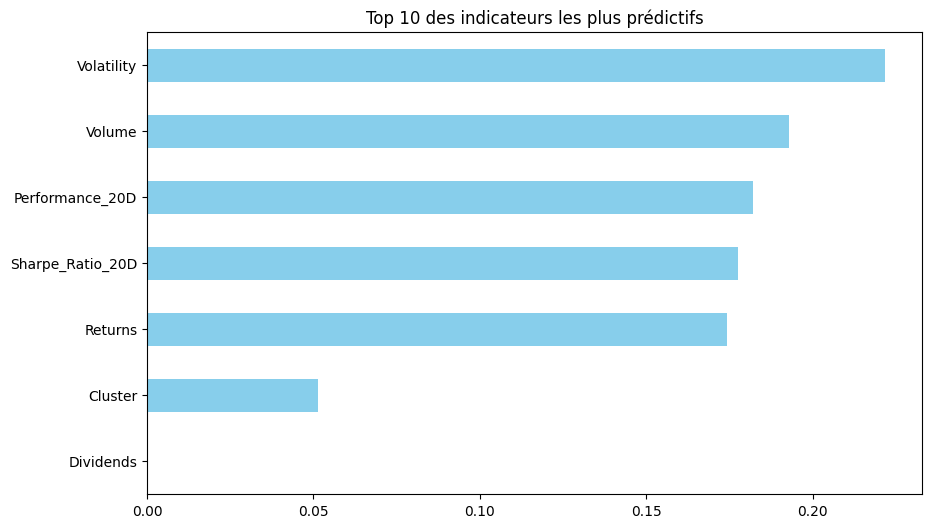

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# --- 1. CONFIGURATION ---
PROJECT_ROOT = Path("/home/onyxia/work/Gestion-portefeuille/")
PATH_SUPERSET = PROJECT_ROOT / "data/processed/cac40_final_superset.csv"

# --- 2. CHARGEMENT DES DONNÉES ---
df = pd.read_csv(PATH_SUPERSET)
# On s'assure que les données sont triées par date
df = df.sort_values('Date')

# --- 3. PRÉPARATION DES FEATURES (X) ET DE LA CIBLE (y) ---
# On retire les colonnes non-prédictives ou qui contiennent la "réponse"
potential_drops = ['Date', 'Ticker', 'Target', 'Target_Next_5D', 'Target_Price', 'Close']
cols_to_drop = [c for c in potential_drops if c in df.columns]

X = df.drop(columns=cols_to_drop)
y = df['Target']

print(f"✅ Features utilisées : {X.columns.tolist()}")

# --- 4. SPLIT TEMPOREL (80% Train / 20% Test) ---
# En finance, on ne mélange pas les données (shuffle=False) 
# car on veut tester le modèle sur le futur par rapport à l'entraînement
split_idx = int(len(df) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# --- 5. ENTRAÎNEMENT DU MODÈLE ---
print("🚀 Entraînement du Random Forest en cours...")
model = RandomForestClassifier(
    n_estimators=200, 
    max_depth=10,      # On limite la profondeur pour éviter le sur-apprentissage
    random_state=42, 
    n_jobs=-1          # Utilise tous les processeurs disponibles
)
model.fit(X_train, y_train)

# --- 6. ÉVALUATION ---
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("\n" + "="*30)
print(f"🎯 ACCURACY SCORE : {accuracy:.2%}")
print("="*30)
print("\n📝 RAPPORT DE CLASSIFICATION :")
print(classification_report(y_test, y_pred))

# --- 7. IMPORTANCE DES FEATURES ---
# Pour voir quels indicateurs aident le plus l'IA
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
importances.head(10).plot(kind='barh', color='skyblue')
plt.title("Top 10 des indicateurs les plus prédictifs")
plt.gca().invert_yaxis()
plt.show()

XGboost

In [3]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# 1. Préparation des données spécifique à XGBoost
# XGBoost préfère les types de données simples
print("🚀 Entraînement de XGBoost en cours...")

model_xgb = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# 2. Entraînement
model_xgb.fit(X_train, y_train)

# 3. Prédiction et Score
y_pred_xgb = model_xgb.predict(X_test)
print(f"🎯 Accuracy XGBoost : {accuracy_score(y_test, y_pred_xgb):.2%}")
print("\n📝 Rapport XGBoost :")
print(classification_report(y_test, y_pred_xgb))

🚀 Entraînement de XGBoost en cours...


/opt/python/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:02:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🎯 Accuracy XGBoost : 53.12%

📝 Rapport XGBoost :
              precision    recall  f1-score   support

           0       0.49      0.16      0.24      9844
           1       0.54      0.85      0.66     11322

    accuracy                           0.53     21166
   macro avg       0.51      0.51      0.45     21166
weighted avg       0.52      0.53      0.47     21166



LSTM

In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from pathlib import Path

# 1. Préparation des données (on utilise une fenêtre de 10 jours)
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# 2. Chargement et Normalisation (Crucial pour le Deep Learning)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # X vient de tes cellules précédentes
X_df_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Création des séquences 3D
TIME_STEPS = 10
X_3d, y_3d = create_sequences(X_df_scaled, y, TIME_STEPS)

# Split temporel
split = int(len(X_3d) * 0.8)
X_train_lstm, X_test_lstm = X_3d[:split], X_3d[split:]
y_train_lstm, y_test_lstm = y_3d[:split], y_3d[split:]

# 3. Architecture du modèle LSTM
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1, activation='sigmoid') # Sigmoid pour une classification binaire (0 ou 1)
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 4. Entraînement
print("🧠 Entraînement du LSTM en cours...")
history = model_lstm.fit(
    X_train_lstm, y_train_lstm, 
    epochs=10, 
    batch_size=32, 
    validation_split=0.1,
    verbose=1
)

# 5. Évaluation
loss, acc = model_lstm.evaluate(X_test_lstm, y_test_lstm)
print(f"🎯 Accuracy LSTM : {acc:.2%}")

🧠 Entraînement du LSTM en cours...
Epoch 1/10


/opt/python/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2381/2381 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - accuracy: 0.4579 - loss: nan - val_accuracy: 0.4829 - val_loss: nan
Epoch 2/10
2381/2381 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.4579 - loss: nan - val_accuracy: 0.4829 - val_loss: nan
Epoch 3/10
2336/2381 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4598 - loss: nan

KeyboardInterrupt: 

SVM

In [9]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# 1. NETTOYAGE RIGOUREUX (Indispensable pour SVM et LSTM)
# On supprime toutes les lignes qui contiennent au moins un NaN
X_clean = X.dropna()
y_clean = y[X_clean.index] # On aligne la cible sur les lignes restantes

print(f"🧹 Lignes supprimées contenant des NaN : {len(X) - len(X_clean)}")

# 2. SPLIT TEMPOREL sur les données propres
split_idx = int(len(X_clean) * 0.8)
X_train, X_test = X_clean.iloc[:split_idx], X_clean.iloc[split_idx:]
y_train, y_test = y_clean.iloc[:split_idx], y_clean.iloc[split_idx:]

# 3. NORMALISATION
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. ENTRAÎNEMENT SVM
print("🚀 Entraînement du SVM sur données propres...")
model_svm = SVC(kernel='rbf', C=1.0, random_state=42)
model_svm.fit(X_train_scaled, y_train)

# 5. SCORE
y_pred_svm = model_svm.predict(X_test_scaled)
print(f"🎯 Accuracy SVM : {accuracy_score(y_test, y_pred_svm):.2%}")

🧹 Lignes supprimées contenant des NaN : 2785
🚀 Entraînement du SVM sur données propres...
🎯 Accuracy SVM : 53.69%
